# Simulations light inter

## 0. Imports

In [1]:
import numpy as np
import time as t
import random
from oawidgets.plantgl import *
from openalea.plantgl.all import Material, Color3, Scene
import oawidgets.mtg

from openalea.archicrop.archicrop import ArchiCrop
from openalea.archicrop.display import build_scene, display_scene
from openalea.archicrop.stics_io import read_sti_file, read_xml_file
from openalea.archicrop.simulation import LHS_param_sampling, params_for_curve_fit
import matplotlib.pyplot as plt
%gui qt

In [2]:
# random.seed(18)

## 1. Set management parameters

Set parameters regarding the spatial (and temporal) configuration of the crop.

In [3]:
file_tec_xml = 'Mais_tec.xml'
params_tec = ['densitesem', 'interrang']
tec_stics = read_xml_file(file_tec_xml, params_tec)
sowing_density = tec_stics['densitesem']
inter_row = 70 # cm

## 2. Format crop-scale growth and senescence dynamics

From crop-scale data either measured or simulated with a crop model, generate a dictionnary of dictionnaries for each day with the following values :
 - "Thermal time" (float): cumulated thermal time from beginning of simulation to current day (in °C.day)
 - "Phenology" (str): current phenological stage (germination, juvenile, exponential or repro)
 - "Plant leaf area" (float): plant leaf area (in cm²) 
 - "Leaf area increment" (float): leaf area increment compared to previous day (in cm²) 
 - "Plant senescent leaf area" (float): senescent plant leaf area (in cm²) 
 - "Senescent leaf area increment" (float): senescent leaf area increment compared to previous day (in cm²) 
 - "Plant height" (float): plant height (in cm) 
 - "Height increment" (float): height increment compared to previous day (in cm).

In [4]:
stics_output_file = 'mod_smaize.sti'
daily_dynamics = read_sti_file(stics_output_file, sowing_density)

# Time series 
# for thermal time, plant leaf area, plant senescent leaf area and plant height
thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
height_canopy = [value["Plant height"] for value in daily_dynamics.values()]

In [5]:
file_plt_xml = 'corn_plt.xml'
params_sen = ['durvieF', 'ratiodurvieI']
sen_stics = read_xml_file(file_plt_xml, params_sen)
lifespan = sen_stics['durvieF'] # leaf lifespan from appearance in exponential phase
lifespan_early = sen_stics['ratiodurvieI'] * lifespan # leaf lifespan from appearance in juvenile phase

## 3. Set plant architectural parameters

Set topological, geometrical and developmental parameters, in a range corresponding a given species, found in literature.

In [6]:
archi = dict(
    nb_phy=[8,20], # number of phytomers on the main stem
    nb_short_phy=4,
    
    # Stem
    height=3*max(height_canopy), # potential plant height
    stem_q=1.0, # parameter for ligule height geometric distribution along axis
    diam_base=2.5, # stem base diameter cm
    diam_top=1.5, # stem top diameter cm

    # Leaf area distribution along the stem  
    leaf_area=1.2*max(leaf_area_plant), # potential plant leaf area
    rmax=[0.55,0.8], # relative position of largest leaf on the stem
    skew=0.005, # skewness for leaf area distribution along axis

    # blade area
    wl=0.12, # leaf blade width-to-length ratio 
    klig=0.6, # parameter for leaf blade shape
    swmax=0.55, # relative position of maximal blade width
    f1=0.64, # parameter for leaf blade shape
    f2=0.92, # parameter for leaf blade shape

    # blade curvature
    insertion_angle=35, # leaf blade insertion angle
    scurv=0.7, #  relative position of inflexion point
    curvature=120, # leaf blade insertion-to-tip angle
    phyllotactic_angle=137.5, # phyllotactic angle
    phyllotactic_deviation=0, # half-deviation to phyllotactic angle

    # Development
    phyllochron=30, # phyllochron, i.e. stem element appearance rate
    plastochron=40, # plastochron, i.e. leaf blade appearance rate

    # Senescence 
    leaf_lifespan = [lifespan_early, lifespan], # leaf lifespan from appearance

    # Tillering
    nb_tillers=0, # number of tillers
    tiller_delay=1, # delay, as factor of phyllochron, between the appearance of a phytomer and the appearance of its tiller
    tiller_angle=30, # degree
    reduction_factor=1, # reduction factor between tillers of consecutive order

    plant_orientation=0 #20 degree
)

In [7]:
# Function to process parameters and generate samples
# Generate parameter sets
param_sets = LHS_param_sampling(archi, daily_dynamics, n_samples=10, seed=18)
print(len(param_sets))

10


In [8]:
# Select parameters sets for which the model fits the LAI and the height curves of the crop model, with a given error.

# Start the timer
start_time = t.time()

fitting_sim, non_fitting_sim = params_for_curve_fit(param_sets, curves=daily_dynamics, error_LA=0.05, error_height=0.05)

# End the timer
end_time = t.time()

# Calculate elapsed time
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes")

Elapsed time: 0.5626 minutes


In [9]:
print(len(fitting_sim['mtg']))

6


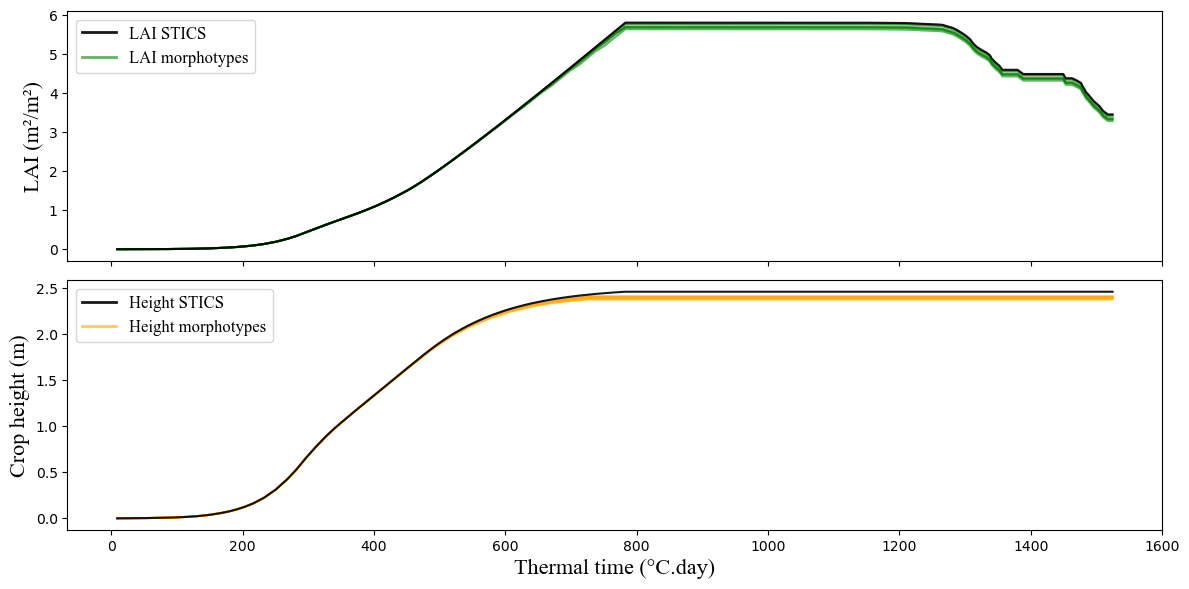

In [10]:
from matplotlib.lines import Line2D

# conversion factor

cf_cm = 100


# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  # 1 row, 2 columns

# Plot on the first subplot
# for non_result in non_fitting_sim['LA']:
#     axes[0].plot(thermal_time, [r*sowing_density/10000 for r in result],  color="gray", alpha=0.1)
for result in fitting_sim['LA']:
    axes[0].plot(thermal_time, [r*sowing_density/cf_cm**2 for r in result],  color="green", alpha=0.6)
    # print(result)
axes[0].plot(thermal_time, [(la-sen)*sowing_density/cf_cm**2 for la, sen in zip(leaf_area_plant, sen_leaf_area_plant)], color="black", alpha=0.9)
# axes[0].set_xlabel("Thermal time (°C.day)")
axes[0].set_ylabel("LAI (m²/m²)", fontsize=16, fontname="Times New Roman")
# axes[0].set_title("Leaf Area: 3D canopy vs. STICS")
# axes[0].legend(loc=2)

legend_elements_lai = [
    Line2D([0], [0], color='black', alpha=0.9, lw=2, label='LAI STICS'),
    Line2D([0], [0], color='green', alpha=0.6, lw=2, label='LAI morphotypes')
]

axes[0].legend(handles=legend_elements_lai, loc=2, prop={'family': 'Times New Roman', 'size': 12})

# Plot on the second subplot
# for non_result in non_fitting_sim['height']:
#     axes[1].plot(thermal_time, [r*0.01 for r in non_result], color="gray", alpha=0.1)
for result in fitting_sim['height']:
    axes[1].plot(thermal_time, [r*0.01 for r in result], color="orange", alpha=0.6)
axes[1].plot(thermal_time, [h*0.01 for h in height_canopy], color="black", alpha=0.9)
axes[1].set_xlabel("Thermal time (°C.day)", fontsize=16, fontname="Times New Roman")
axes[1].set_ylabel("Crop height (m)", fontsize=16, fontname="Times New Roman")
# axes[1].set_title("Plant height: 3D canopy vs. STICS")

legend_elements_height = [
    Line2D([0], [0], color='black', alpha=0.9, lw=2, label='Height STICS'),
    Line2D([0], [0], color='orange', alpha=0.6, lw=2, label='Height morphotypes')
]

axes[1].legend(handles=legend_elements_height, loc=2, prop={'family': 'Times New Roman', 'size': 12})

plt.savefig('PMA_curves')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
# fitting_sim['mtg'][-1][85].properties()

In [1]:
# scene, _ = build_scene(fitting_sim['mtg'][1][60])
# PlantGL(scene)

In [13]:
# morpho = {
#     i : [p['nb_phy'],p['rmax']]
#     for i,p in enumerate(fitting_sim['params'])
# }

# print(morpho)
# print([p['nb_phy'] for p in fitting_sim['params']])
# print([round(p['wl'],2) for p in fitting_sim['params']])

## Light interception

In [ ]:
# faire au zenith aussi !!!!!!!!!!!!!!!!!!!!
# ciel 6 directions, 16, 36...

In [14]:
import pandas as pd
from openalea.astk.sky_irradiance import sky_irradiance
from openalea.astk.sky_sources import sky_sources, caribu_light_sources
from openalea.archicrop.ltfs import illuminate, mean_leaf_irradiance
from alinea.caribu.data_samples import data_path

par_incident = par_inc = [value["Incident PAR"] for value in daily_dynamics.values()]

fn = 'climaisj.meteo'
def meteo_day(dates):
    names=['station', 'year', 'month', 'day', 'julian', 'min_temp', 'max_temp', 'rad', 'Penman PET', 'rainfall', 'wind', 'pressure', 'CO2']
    df = pd.read_csv(fn,  header=None, sep='\s+', names=names)
    df["daydate"] = pd.to_datetime(df[["year", "month", "day"]])
    return df

def year_to_season():
    pass

df = meteo_day()
location ={
'longitude': 3.87,
'latitude': 45,
'altitude': 56,
'timezone': 'Europe/Paris'}

# print([d for d in df.itertuples()])

# irr = sky_irradiance()
# sun, sky = sky_sources(sky_type='clear_sky', sky_irradiance=irr, scale='ppfd')
# lights = caribu_light_sources(sun, sky)

nice_green = Color3((50,100,0))

inter_plant = (100 / inter_row / sowing_density)*100 
domain = ((-0.5*inter_row, -0.5*inter_plant), (0.5*inter_row, 0.5*inter_plant))

par_caribu = []

scenes = []

start_time = t.time()

for mtgs in fitting_sim['mtg'][:1]:
    scenes_tmp = []
    aggs_tmp = []
    count = 0
    print(len(mtgs))
    # for mtg, par in zip(mtgs[-2:-1], par_inc[-2:-1]):
    for mtg,row in zip(mtgs,df.itertuples()): # reduire df --> request
        # count += 1
        # if count%5==0:
        irr = sky_irradiance(daydate=row.daydate, day_ghi=row.rad, **location)
        sun, sky = sky_sources(sky_type='clear_sky', sky_irradiance=irr, scale='global')
        lights = caribu_light_sources(sun, sky)
        # lights = [(par,(0,0,-1))]
        
        scene, labels = build_scene(mtg, (0,0,0), leaf_material=Material(nice_green), stem_material=Material(nice_green), senescence=False)
        cs, raw, agg = illuminate(scene, light=lights, labels=labels, domain=domain) # --> cf PARaggregators in caribu scene node
        aggs_tmp.append(agg)
        scenes_tmp.append(cs.plot(raw, display=False)[0])
        # print((t.time() - start_time)/60)
    par_caribu.append(aggs_tmp)
    scenes.append(scenes_tmp)

end_time = t.time()

elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes for {len(fitting_sim['mtg'])} simulations")

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\cheriere\AppData\Local\Temp\ipykernel_32096\3331826224.py:12: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(fn,  header=None, sep='\s+', names=names)


170
170
170
170
170
170
Elapsed time: 205.5990 minutes for 6 simulations


In [97]:
mdf=meteo_day()
min_date = pd.to_datetime('%d/%d/%d'%(1996, 4, 21))
max_date = pd.to_datetime('%d/%d/%d'%(1996, 10, 25))
mdf = mdf[mdf.daydate>=min_date]
mdf = mdf[mdf.daydate<max_date]
print(mdf)


     station  year  month  day  julian  min_temp  max_temp   rad  Penman PET  \
111  climais  1996      4   21     112      10.3      23.3  17.8         5.1   
112  climais  1996      4   22     113      10.0      23.2  15.2         3.6   
113  climais  1996      4   23     114      10.1      15.0  17.3         2.6   
114  climais  1996      4   24     115       5.6      15.3  21.8         2.4   
115  climais  1996      4   25     116       4.5      15.6  22.9         2.5   
..       ...   ...    ...  ...     ...       ...       ...   ...         ...   
293  climais  1996     10   20     294       7.9      18.5   9.2         0.9   
294  climais  1996     10   21     295      13.6      19.8   3.3         0.6   
295  climais  1996     10   22     296       9.5      18.3  11.2         1.2   
296  climais  1996     10   23     297       6.9      23.6  11.8         1.9   
297  climais  1996     10   24     298       9.0      21.5  10.0         1.7   

     rainfall   wind  pressure    CO2  

In [15]:
par_stics = [value["Absorbed PAR"] for value in daily_dynamics.values()]

nrj_per_leaf = []
irr_per_plant = []

for case in par_caribu:
    nrj_tmp = []
    irr_tmp = []
    for df in case:
        df_mod = mean_leaf_irradiance(df)
        nrj_tmp.append(df.loc[df['label'] == 'Leaf']['Energy'].values)
        irr_tmp.append(df_mod['Irradiance'].values[0])
    nrj_per_leaf.append(nrj_tmp)
    irr_per_plant.append(irr_tmp)

In [64]:
df # area in m2 or cm2 !!!!!!!!!!!!!!!!!!!!!!!

,plant,vid,label,is_green,index,Eabs,Ei,area,Energy
0,0,3,Stem,True,3,0.007212,0.008290,0.001207,0.000009
1,0,4,Leaf,True,4,0.290905,0.334373,0.000714,0.000208
2,0,5,Stem,True,5,0.035539,0.040849,0.001142,0.000041
3,0,6,Leaf,True,6,0.212502,0.244255,0.000028,0.000006
4,0,7,Stem,True,7,0.198227,0.227847,0.001070,0.000212
5,0,8,Leaf,True,8,0.774985,0.890787,0.000936,0.000725
6,0,9,Stem,True,9,0.185189,0.212861,0.000961,0.000178
7,0,10,Leaf,True,10,0.117480,0.135035,0.000205,0.000024
8,0,11,Stem,True,11,0.189565,0.217891,0.015602,0.002958
9,0,12,Leaf,True,12,0.322995,0.371259,0.006399,0.002067


In [32]:
print(len(nrj_per_leaf))
print(len(nrj_per_leaf[-1]))
print(len(nrj_per_leaf[-1][-1]))
nrj_per_plant = [[sum(growing_plant) for growing_plant in plant] for plant in nrj_per_leaf]
nrj_per_plant

6
170
14


[[8.216e-08,
  3.822147e-06,
  2.5914336000000002e-05,
  3.4635405e-05,
  3.0041050000000003e-05,
  6.703522800000001e-05,
  0.00034058428399999995,
  0.000582201798,
  0.000562428256,
  0.000477952168,
  0.000947814099,
  0.0035142527949999997,
  0.002873483314,
  0.004115421783,
  0.005877858985,
  0.00812822029,
  0.00882740774,
  0.015396045253,
  0.020213394081,
  0.016629069732,
  0.022683781496,
  0.007491792979,
  0.03285413737,
  0.055269414422,
  0.042140689198,
  0.031878744408,
  0.053544862335,
  0.09433182285700001,
  0.21739985184900001,
  0.368223220169,
  0.121594582594,
  0.5642054539970001,
  0.172040629525,
  0.31024216925400006,
  0.40318936593000004,
  0.6738903974370001,
  0.270490970268,
  0.40953313441899997,
  0.8777775556169999,
  0.858132701313,
  0.8558130058250001,
  1.01170611195,
  0.590169590809,
  0.9186666021759999,
  0.256893147927,
  1.4275598366030002,
  0.37595882401,
  0.596988961446,
  0.235129492743,
  0.5448794396259999,
  0.5867632191140001,


In [17]:
# Conversion
# irr_per_plant = [[i*0.0864/4.6  for i in irr] for irr in irr_per_plant]
# irr_per_plant

In [35]:
par_inc

[6.8856,
 11.1264,
 9.2568,
 6.2472,
 7.0224,
 10.1688,
 7.7976,
 8.4816,
 8.0256,
 7.7064,
 10.26,
 7.1592,
 9.5304,
 9.2568,
 5.1072,
 10.5792,
 1.2768,
 4.56,
 4.1952,
 9.0744,
 13.3152,
 12.8136,
 5.4264,
 7.296,
 10.1232,
 12.2208,
 13.2696,
 13.2696,
 12.9048,
 12.6768,
 8.0712,
 11.628,
 11.2632,
 12.1752,
 11.9928,
 13.7712,
 13.7256,
 13.7712,
 13.7712,
 13.5432,
 12.8592,
 10.6704,
 10.1232,
 2.4168,
 10.5336,
 10.3056,
 11.2632,
 7.6152,
 8.5728,
 12.2208,
 12.3576,
 10.1232,
 13.1784,
 5.7,
 8.664,
 4.0128,
 4.4688,
 8.1624,
 8.6184,
 3.2376,
 10.3056,
 11.0808,
 6.156,
 12.54,
 11.6736,
 10.5336,
 12.768,
 12.6768,
 12.7224,
 13.1784,
 13.3152,
 12.6312,
 12.8136,
 12.9048,
 12.1752,
 10.3056,
 12.084,
 10.8528,
 10.9896,
 11.4456,
 10.7616,
 8.3448,
 8.1624,
 10.716,
 10.032,
 8.1624,
 11.9016,
 9.3936,
 4.332,
 3.5112,
 9.9864,
 11.3088,
 8.892,
 3.0096,
 7.1592,
 7.7976,
 9.5304,
 9.5304,
 9.9408,
 11.172,
 10.8072,
 10.8072,
 8.9832,
 5.0616,
 2.9184,
 8.8008,
 7.9344,

In [ ]:
# Energy in Caribu : W = 0.0864 MJ.day-1
# Irradiance in Caribu : W.m-2 = 0.0864 MJ.m[leaf]-2.day-1
# Incident PAR in STICS : MJ.m[soil]-2.day-1
# Absorbed PAR in STICS : MJ.m[soil]-2.day-1

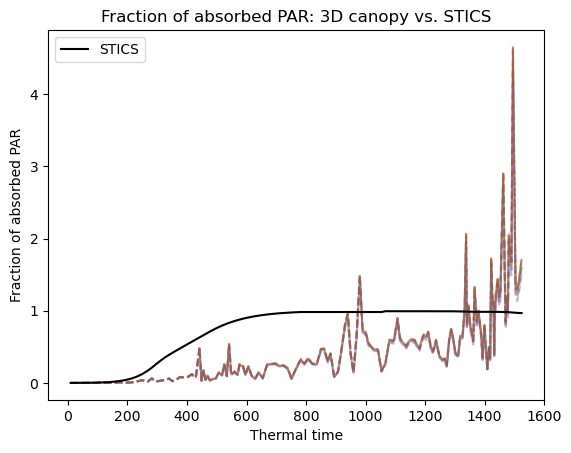

In [88]:
curves = nrj_per_plant
# curves_array = np.array(curves)

# # Calculate the envelope: min and max values for each time point
# min_values = curves_array.min(axis=0)
# max_values = curves_array.max(axis=0)

# Plotting the envelope along with individual curves for context
time_points = thermal_time
for curve in curves:
    plt.plot(time_points, [i/sowing_density/0.0864/par for i,par in zip(curve, par_inc)], alpha=0.5, linestyle='--')  # Plot each curve (optional for visualization)
    # plt.plot([t for c,t in enumerate(time_points) if c%5==0 and c!=0], [i/par for i,par in zip(curve, [r for c,r in enumerate(par_inc) if c%5==0 and c!=0])], color='orange', label="ArchiCrop x Caribu")

# plt.fill_between(time_points, min_values, max_values, color="skyblue", alpha=0.4)
# plt.plot(time_points, min_values, color="blue", linestyle="--", label="Min 3D")
# plt.plot(time_points, max_values, color="red", linestyle="--", label="Max 3D")
plt.plot(time_points, par_stics, color="black", label="STICS")
# plt.scatter(time_points, LA_stics)

# Labels and legend
plt.xlabel("Thermal time") # ----> also date !!!!!!!!!!!!!!!!
plt.ylabel("Fraction of absorbed PAR")
plt.title("Fraction of absorbed PAR: 3D canopy vs. STICS")
plt.legend()
plt.show()

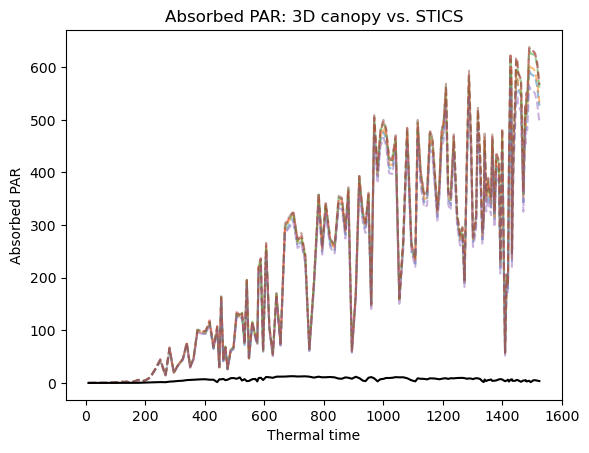

In [72]:
for curve in curves:
    plt.plot(time_points, [i*sowing_density/0.0864 for i,par in zip(curve, par_inc)], alpha=0.5, linestyle='--')  # Plot each curve (optional for visualization)

plt.plot(time_points, [i*par for i,par in zip(par_stics, par_inc)], color="black", label="STICS")
# plt.plot(thermal_time, raint)

# Labels and legend
plt.xlabel("Thermal time")
plt.ylabel("Absorbed PAR")
plt.title("Absorbed PAR: 3D canopy vs. STICS")
# plt.legend()
plt.show()

In [19]:
# corresponding dates for par_inc STICS and meteo_day astk

# senescence = True

# test direct True and False

$$ raint(t)=0.95⋅parsurrgG⋅trg(t)⋅(1−exp(−extinP⋅(lai(t)+eai(t)))) $$

$$ parsurrgG = 0.48 $$

$$ extinP(maize) = 0.7 $$

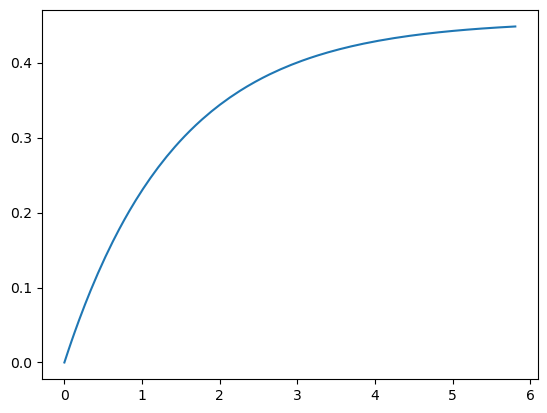

In [50]:
import math

extinp = 0.7
lai = [la*sowing_density/10000  for la in leaf_area_plant]
raint_sur_trg = [0.95*0.48*(1-math.exp(-extinp*la)) for la in lai]
plt.plot(lai, raint_sur_trg)
plt.show()

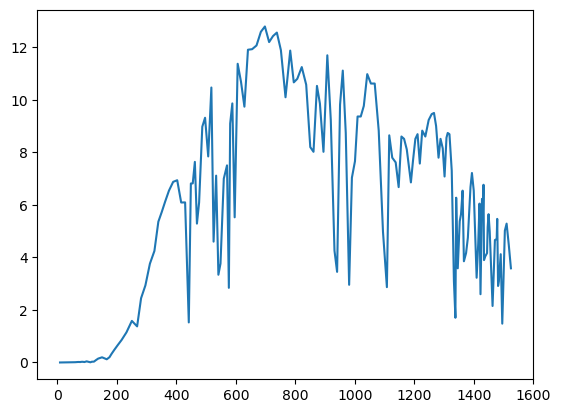

In [52]:
raint = [par*(1-math.exp(-extinp*la)) for la,par in zip(lai, par_inc)]
plt.plot(thermal_time, raint)
plt.show()

In [38]:
PlantGL(scenes[0][-4])

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [21]:
inter_row = 70
inter_plant = (100 / inter_row / sowing_density)*100 
print(inter_plant)
domain = ((-0.5*inter_row, -0.5*inter_plant), (0.5*inter_row, 0.5*inter_plant))
print(domain)

15.037593984962406
((-35.0, -7.518796992481203), (35.0, 7.518796992481203))


In [83]:
(domain[1][0] - domain[0][0]) * (domain[1][1] - domain[0][1]) * 9.5

10000.0

In [22]:
sowing_density

9.5

In [ ]:
weather = meteo_day()

In [78]:
l = []
for row in weather.itertuples():
    irr = sky_irradiance(daydate=row.daydate, day_ghi=row.rad, **location)
    sun, sky = sky_sources(sky_type='clear_sky', sky_irradiance=irr, scale='global')
    lights = caribu_light_sources(sun, sky)
    l.append(sum([light[0] for light in lights]))

366


In [87]:
l[31+29+31+21]

33.73962856348898

In [84]:
par_inc

[6.8856,
 11.1264,
 9.2568,
 6.2472,
 7.0224,
 10.1688,
 7.7976,
 8.4816,
 8.0256,
 7.7064,
 10.26,
 7.1592,
 9.5304,
 9.2568,
 5.1072,
 10.5792,
 1.2768,
 4.56,
 4.1952,
 9.0744,
 13.3152,
 12.8136,
 5.4264,
 7.296,
 10.1232,
 12.2208,
 13.2696,
 13.2696,
 12.9048,
 12.6768,
 8.0712,
 11.628,
 11.2632,
 12.1752,
 11.9928,
 13.7712,
 13.7256,
 13.7712,
 13.7712,
 13.5432,
 12.8592,
 10.6704,
 10.1232,
 2.4168,
 10.5336,
 10.3056,
 11.2632,
 7.6152,
 8.5728,
 12.2208,
 12.3576,
 10.1232,
 13.1784,
 5.7,
 8.664,
 4.0128,
 4.4688,
 8.1624,
 8.6184,
 3.2376,
 10.3056,
 11.0808,
 6.156,
 12.54,
 11.6736,
 10.5336,
 12.768,
 12.6768,
 12.7224,
 13.1784,
 13.3152,
 12.6312,
 12.8136,
 12.9048,
 12.1752,
 10.3056,
 12.084,
 10.8528,
 10.9896,
 11.4456,
 10.7616,
 8.3448,
 8.1624,
 10.716,
 10.032,
 8.1624,
 11.9016,
 9.3936,
 4.332,
 3.5112,
 9.9864,
 11.3088,
 8.892,
 3.0096,
 7.1592,
 7.7976,
 9.5304,
 9.5304,
 9.9408,
 11.172,
 10.8072,
 10.8072,
 8.9832,
 5.0616,
 2.9184,
 8.8008,
 7.9344,

In [ ]:
# see if sum eabs and esoil = 1 !!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# see tests caribu !!!!!!!!!!!!!! cf light vege manager in oa incubator

In [ ]:
# compute memory 

In [ ]:
"""
# vertical light interception
cs, ei, df = illuminate(scene, scene_unit='cm')
cs.plot(ei)


# diffuse light interception
sources = skys.sky_sources()
cs, ei, df = illuminate(scene, light=sources, scene_unit='cm')
cs.plot(ei)

# get score per plant
def score(res):
    return pd.Series({'ei':(res.Ei*res.area).sum() / res.area.sum(),
                              'area': res.area.sum()})
df['nump']=nump
df.groupby('nump').apply(score)
"""